In [1]:
"""
================================================================================
NOTEBOOK 09: TEMPLATE VS LEARNED COMPARISON
================================================================================
Copyright (c) 2026 Ajay Mahale. All Rights Reserved.
License: CC BY-NC-ND 4.0
https://creativecommons.org/licenses/by-nc-nd/4.0/


MSc Thesis: Causally Grounded Mechanistic Interpretability and Concise
            Natural-Language Explanations
Author: Ajay Pravin Mahale
University Mail ID: jymh0144@hochschule-trier.de
Personal Mail ID: Mahale.ajay01@gmail.com
Institution: Hochschule Trier
Supervisor: Prof. Dr. Ernst Georg Haffner

Purpose: Quantitative comparison of template-based vs LLM-generated explanations.

Sample Size: n=30 prompts (API cost constraint)

KEY RESULTS:
- Template quality: 60%
- Learned quality: 98%
- Improvement: +63%

GitHub:(uses Claude API)
================================================================================
"""

# ==============================================================================
# CELL 1: Install
# ==============================================================================

!pip install -q transformer-lens anthropic

print("Install done")

Install done


In [2]:
# ==============================================================================
# CELL 2: REPRODUCIBILITY SETUP + IMPORTS
# ==============================================================================

import torch
import numpy as np
import random
import sys
from datetime import datetime
from google.colab import drive

drive.mount('/content/drive')

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
print(f"✅ Seed set: {SEED}")

print("=" * 60)
print("NOTEBOOK 09: TEMPLATE VS LEARNED COMPARISON")
print("=" * 60)
print(f"Random Seed:     {SEED}")
print(f"Sample Size:     n=30 (API cost constraint)")
print(f"Timestamp:       {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 60)

from transformer_lens import HookedTransformer
import anthropic
import matplotlib.pyplot as plt

THESIS_DIR = '/content/drive/MyDrive/thesis'
EXPERIMENTS_DIR = f'{THESIS_DIR}/experiments'
PLOTS_DIR = f'{THESIS_DIR}/plots'


import matplotlib.pyplot as plt
import anthropic
from google.colab import userdata
from transformer_lens import HookedTransformer

# GPU Check
if not torch.cuda.is_available():
    print("❌ NO GPU. Go to Runtime → Change runtime type → T4 GPU")
    raise RuntimeError("GPU required")

print(f"✅ GPU: {torch.cuda.get_device_name(0)}")

# API setup
try:
    api_key = userdata.get('ANTHROPIC_API_KEY')
    client = anthropic.Anthropic(api_key=api_key.strip())
    print("✅ Claude API connected")
except Exception as e:
    print(f"❌ API Error: {e}")
    raise

# Load model
print("Loading GPT-2 Small...")
model = HookedTransformer.from_pretrained("gpt2-small")
model.cuda()
print(f"✅ Model loaded on {model.cfg.device}")

# Circuit heads from Notebook 02
our_head_importance = {
    (9, 9): 0.174, (8, 10): 0.123, (7, 3): 0.103,
    (10, 6): 0.089, (9, 6): 0.063, (10, 0): 0.062,
}

NOT_NAMES = {'When', 'The', 'Then', 'There', 'They', 'This', 'That', 'What', 'Where', 'Who', 'How'}

# Full dataset (50 prompts)
name_pairs = [
    ("Mary", "John"), ("Alice", "Bob"), ("Sarah", "Tom"), ("Emma", "James"),
    ("Lisa", "David"), ("Anna", "Michael"), ("Sophie", "Daniel"), ("Rachel", "Chris"),
    ("Laura", "Kevin"), ("Julia", "Peter"), ("Diana", "Steve"), ("Helen", "Mark"),
    ("Grace", "Paul"), ("Claire", "Andrew"), ("Emily", "Ryan"), ("Olivia", "Nathan"),
    ("Mia", "Lucas"), ("Ella", "Henry"), ("Lily", "Jack"), ("Zoe", "Sam"),
    ("Kate", "Ben"), ("Amy", "Luke"), ("Nina", "Max"), ("Eva", "Leo"), ("Iris", "Adam"),
]

templates_ioi = [
    "When {name1} and {name2} went to the store, {name2} gave a drink to",
    "When {name1} and {name2} went to the park, {name2} handed a flower to",
]

all_prompts = []
for name1, name2 in name_pairs:
    for template in templates_ioi:
        all_prompts.append(template.format(name1=name1, name2=name2))

print(f"✅ {len(all_prompts)} prompts ready")
print(f"✅ Setup complete")

Mounted at /content/drive
✅ Seed set: 42
NOTEBOOK 09: TEMPLATE VS LEARNED COMPARISON
Random Seed:     42
Sample Size:     n=30 (API cost constraint)
Timestamp:       2026-02-06 14:34:52
✅ GPU: Tesla T4
✅ Claude API connected
Loading GPT-2 Small...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda
✅ Model loaded on cuda
✅ 50 prompts ready
✅ Setup complete


In [3]:
# ==============================================================================
# CELL 3: Define All Functions
# ==============================================================================

def get_circuit_data(prompt, model):
    """Extract mechanistic circuit data from GPT-2."""

    tokens = model.to_tokens(prompt)
    token_strs = model.to_str_tokens(prompt)
    logits, cache = model.run_with_cache(tokens)

    pred_token = logits[0, -1].argmax().item()
    prediction = model.to_string([pred_token]).strip()
    confidence = torch.softmax(logits[0, -1], dim=-1)[pred_token].item()

    names = []
    for i, tok in enumerate(token_strs):
        tok_clean = tok.strip()
        if (tok_clean and tok_clean[0].isupper() and tok_clean.isalpha() and
            len(tok_clean) > 1 and tok_clean not in NOT_NAMES):
            if tok_clean not in [n[1] for n in names]:
                names.append((i, tok_clean))

    attention_data = {}
    key_heads = [(9, 9), (9, 6), (8, 10), (7, 3)]

    for layer, head in key_heads:
        pattern = cache[f"blocks.{layer}.attn.hook_pattern"][0, head, -1]
        head_name = f"L{layer}H{head}"
        attention_data[head_name] = {}
        for pos, name in names:
            attention_data[head_name][name] = f"{pattern[pos].item():.1%}"

    return {
        'prompt': prompt,
        'prediction': prediction,
        'confidence': f"{confidence:.1%}",
        'confidence_float': confidence,
        'names': [n[1] for n in names],
        'attention': attention_data,
        'indirect_object': names[0][1] if names else None,
        'subject': names[1][1] if len(names) > 1 else None,
    }


def generate_template_explanation(circuit_data):
    """Template-based explanation (baseline)."""
    return f"The model predicts '{circuit_data['prediction']}' because L9H9 and L9H6 attend to it with high attention, copying the indirect object to output position."


def generate_learned_explanation(circuit_data, client):
    """LLM-generated explanation (novel)."""

    user_prompt = f"""You are an AI interpretability expert. Explain this GPT-2 prediction in 1-2 sentences.

INPUT: "{circuit_data['prompt']}"
PREDICTION: "{circuit_data['prediction']}" (confidence: {circuit_data['confidence']})

MECHANISTIC DATA:
- Indirect object: {circuit_data['indirect_object']}
- Subject: {circuit_data['subject']}
- L9H9 attention: {circuit_data['attention'].get('L9H9', {})}
- L9H6 attention: {circuit_data['attention'].get('L9H6', {})}

Rules: Be concise, mention specific heads with percentages, no hedging."""

    response = client.messages.create(
        model="claude-sonnet-4-20250514",
        max_tokens=100,
        messages=[{"role": "user", "content": user_prompt}]
    )

    return response.content[0].text.strip()


def evaluate_faithfulness(prompt, model, head_importance, k=6):
    """ERASER-style faithfulness evaluation."""

    tokens = model.to_tokens(prompt)
    token_strs = model.to_str_tokens(prompt)

    names = []
    for i, tok in enumerate(token_strs):
        tok_clean = tok.strip()
        if (tok_clean and tok_clean[0].isupper() and tok_clean.isalpha() and
            len(tok_clean) > 1 and tok_clean not in NOT_NAMES):
            if tok_clean not in [n[1] for n in names]:
                names.append((i, tok_clean))

    if len(names) < 2:
        return None

    indirect_obj, subject = names[0][1], names[1][1]

    try:
        io_tok = model.to_single_token(" " + indirect_obj)
        subj_tok = model.to_single_token(" " + subject)
    except:
        return None

    logits, cache = model.run_with_cache(tokens)
    clean_diff = (logits[0, -1, io_tok] - logits[0, -1, subj_tok]).item()

    if clean_diff <= 0:
        return None

    # Direct logit attribution
    logit_diff_dir = model.W_U[:, io_tok] - model.W_U[:, subj_tok]
    head_contributions = {}
    for layer in range(model.cfg.n_layers):
        z = cache[f"blocks.{layer}.attn.hook_z"]
        W_O = model.W_O[layer]
        for head in range(model.cfg.n_heads):
            head_out = z[0, -1, head, :]
            head_contribution = head_out @ W_O[head]
            contribution = (head_contribution @ logit_diff_dir).item()
            head_contributions[(layer, head)] = contribution

    top_heads = sorted(head_importance.items(), key=lambda x: -x[1])[:k]
    top_head_set = set([h[0] for h in top_heads])

    # Sufficiency
    cited_contribution = sum(head_contributions.get(h, 0) for h in top_head_set)
    sufficiency = cited_contribution / clean_diff if clean_diff > 0 else 0

    # Comprehensiveness
    def remove_important(activation, hook):
        layer = int(hook.name.split('.')[1])
        new_activation = activation.clone()
        for head in range(activation.shape[2]):
            if (layer, head) in top_head_set:
                new_activation[:, :, head, :] = 0
        return new_activation

    hook_names = [f"blocks.{l}.attn.hook_z" for l in range(model.cfg.n_layers)]
    comp_logits = model.run_with_hooks(
        tokens,
        fwd_hooks=[(name, remove_important) for name in hook_names]
    )
    comp_diff = (comp_logits[0, -1, io_tok] - comp_logits[0, -1, subj_tok]).item()
    comprehensiveness = 1 - (comp_diff / clean_diff) if clean_diff > 0 else 0

    return {
        'sufficiency': max(0, min(1, sufficiency)),
        'comprehensiveness': max(0, min(1, comprehensiveness)),
    }


def score_explanation(text, circuit):
    """Score explanation quality (0-1)."""
    scores = {}

    # 1. Mentions specific heads
    scores['heads'] = 1.0 if ('L9H9' in text or 'L9H6' in text) else 0.0

    # 2. Includes percentages
    scores['percentages'] = 1.0 if '%' in text else 0.0

    # 3. Mentions prediction
    scores['prediction'] = 1.0 if circuit['prediction'].strip() in text else 0.0

    # 4. Mentions indirect object
    scores['indirect_obj'] = 1.0 if circuit['indirect_object'] in text else 0.0

    # 5. Mentions subject
    scores['subject'] = 1.0 if circuit['subject'] in text else 0.0

    scores['overall'] = np.mean(list(scores.values()))
    scores['word_count'] = len(text.split())

    return scores


print("✅ All functions defined")

✅ All functions defined


In [4]:
# ==============================================================================
# CELL 4: Full Comparison (n=30)
# ==============================================================================

# Use 30 prompts (balance between thoroughness and API cost)
test_prompts = all_prompts[:30]

print("=" * 70)
print("FULL COMPARISON: Template vs Learned Explanations")
print(f"Testing on {len(test_prompts)} prompts (~$0.30 API cost)")
print("=" * 70)

results = []

for i, prompt in enumerate(test_prompts):
    # Get circuit data
    circuit_data = get_circuit_data(prompt, model)

    # Generate explanations
    template_expl = generate_template_explanation(circuit_data)

    try:
        learned_expl = generate_learned_explanation(circuit_data, client)
    except Exception as e:
        learned_expl = f"[Error: {e}]"

    # Get ERASER faithfulness
    faithfulness = evaluate_faithfulness(prompt, model, our_head_importance, k=6)

    # Score explanations
    template_score = score_explanation(template_expl, circuit_data)
    learned_score = score_explanation(learned_expl, circuit_data)

    results.append({
        'prompt': prompt,
        'prediction': circuit_data['prediction'],
        'confidence': circuit_data['confidence_float'],
        'template_explanation': template_expl,
        'learned_explanation': learned_expl,
        'template_score': template_score,
        'learned_score': learned_score,
        'sufficiency': faithfulness['sufficiency'] if faithfulness else None,
        'comprehensiveness': faithfulness['comprehensiveness'] if faithfulness else None,
        'circuit_data': circuit_data,
    })

    if (i + 1) % 10 == 0:
        print(f"   Processed {i+1}/{len(test_prompts)}...")

print(f"\n✅ Generated {len(results)} comparison pairs")

FULL COMPARISON: Template vs Learned Explanations
Testing on 30 prompts (~$0.30 API cost)
   Processed 10/30...
   Processed 20/30...
   Processed 30/30...

✅ Generated 30 comparison pairs


In [5]:
# ==============================================================================
# CELL 5: Results Analysis
# ==============================================================================

print("=" * 70)
print("RESULTS ANALYSIS")
print("=" * 70)

# Filter valid results
valid_results = [r for r in results if r['sufficiency'] is not None]

# ERASER metrics
suff_values = [r['sufficiency'] for r in valid_results]
comp_values = [r['comprehensiveness'] for r in valid_results]
f1 = 2 * np.mean(suff_values) * np.mean(comp_values) / (np.mean(suff_values) + np.mean(comp_values))

print(f"\n ERASER FAITHFULNESS METRICS (n={len(valid_results)})")
print("-" * 50)
print(f"   Sufficiency:        {np.mean(suff_values):.1%} ± {np.std(suff_values):.1%}")
print(f"   Comprehensiveness:  {np.mean(comp_values):.1%} ± {np.std(comp_values):.1%}")
print(f"   F1 Score:           {f1:.1%}")

# Quality scores
template_overall = [r['template_score']['overall'] for r in results]
learned_overall = [r['learned_score']['overall'] for r in results]

print(f"\n EXPLANATION QUALITY COMPARISON")
print("-" * 50)
print(f"   {'Method':<20} {'Mean Score':>12} {'Std Dev':>12}")
print(f"   {'-'*44}")
print(f"   {'Template':<20} {np.mean(template_overall):>11.1%} {np.std(template_overall):>11.1%}")
print(f"   {'LLM-based':<20} {np.mean(learned_overall):>11.1%} {np.std(learned_overall):>11.1%}")

improvement = (np.mean(learned_overall) - np.mean(template_overall)) / np.mean(template_overall) * 100
print(f"\n   ✅ Learned is {improvement:+.0f}% better than Template")

# Detailed metrics
template_heads = np.mean([r['template_score']['heads'] for r in results])
learned_heads = np.mean([r['learned_score']['heads'] for r in results])

template_pct = np.mean([r['template_score']['percentages'] for r in results])
learned_pct = np.mean([r['learned_score']['percentages'] for r in results])

template_io = np.mean([r['template_score']['indirect_obj'] for r in results])
learned_io = np.mean([r['learned_score']['indirect_obj'] for r in results])

template_subj = np.mean([r['template_score']['subject'] for r in results])
learned_subj = np.mean([r['learned_score']['subject'] for r in results])

template_len = np.mean([r['template_score']['word_count'] for r in results])
learned_len = np.mean([r['learned_score']['word_count'] for r in results])

print(f"\n DETAILED METRIC BREAKDOWN")
print("-" * 65)
print(f"   {'Metric':<25} {'Template':>12} {'Learned':>12} {'Winner':>12}")
print(f"   {'-'*61}")
print(f"   {'Mentions heads':<25} {template_heads:>11.0%} {learned_heads:>11.0%} {'Tie' if template_heads == learned_heads else 'Learned' if learned_heads > template_heads else 'Template':>12}")
print(f"   {'Uses percentages':<25} {template_pct:>11.0%} {learned_pct:>11.0%} {'Tie' if template_pct == learned_pct else 'Learned' if learned_pct > template_pct else 'Template':>12}")
print(f"   {'Mentions indirect obj':<25} {template_io:>11.0%} {learned_io:>11.0%} {'Tie' if template_io == learned_io else 'Learned' if learned_io > template_io else 'Template':>12}")
print(f"   {'Mentions subject':<25} {template_subj:>11.0%} {learned_subj:>11.0%} {'Tie' if template_subj == learned_subj else 'Learned' if learned_subj > template_subj else 'Template':>12}")
print(f"   {'Avg word count':<25} {template_len:>11.1f} {learned_len:>11.1f} {'--':>12}")

# Winner count
winners = []
for r in results:
    if r['learned_score']['overall'] > r['template_score']['overall']:
        winners.append('Learned')
    elif r['template_score']['overall'] > r['learned_score']['overall']:
        winners.append('Template')
    else:
        winners.append('Tie')

print(f"\n WINNER BREAKDOWN")
print("-" * 50)
print(f"   Learned wins:  {winners.count('Learned'):>3} ({winners.count('Learned')/len(winners)*100:.0f}%)")
print(f"   Template wins: {winners.count('Template'):>3} ({winners.count('Template')/len(winners)*100:.0f}%)")
print(f"   Ties:          {winners.count('Tie'):>3} ({winners.count('Tie')/len(winners)*100:.0f}%)")

# Example comparison
print(f"\n EXAMPLE COMPARISON")
print("-" * 70)
ex = results[0]
print(f"Prompt: ...{ex['prompt'][-45:]}")
print(f"Prediction: {ex['prediction']} ({ex['confidence']:.1%})")
print(f"\nTEMPLATE (score: {ex['template_score']['overall']:.0%}):")
print(f"   {ex['template_explanation']}")
print(f"\nLEARNED (score: {ex['learned_score']['overall']:.0%}):")
print(f"   {ex['learned_explanation']}")


RESULTS ANALYSIS

 ERASER FAITHFULNESS METRICS (n=30)
--------------------------------------------------
   Sufficiency:        100.0% ± 0.0%
   Comprehensiveness:  22.2% ± 14.7%
   F1 Score:           36.3%

 EXPLANATION QUALITY COMPARISON
--------------------------------------------------
   Method                 Mean Score      Std Dev
   --------------------------------------------
   Template                   60.0%        0.0%
   LLM-based                  99.3%        3.6%

   ✅ Learned is +66% better than Template

 DETAILED METRIC BREAKDOWN
-----------------------------------------------------------------
   Metric                        Template      Learned       Winner
   -------------------------------------------------------------
   Mentions heads                   100%        100%          Tie
   Uses percentages                   0%        100%      Learned
   Mentions indirect obj            100%        100%          Tie
   Mentions subject                   0%      

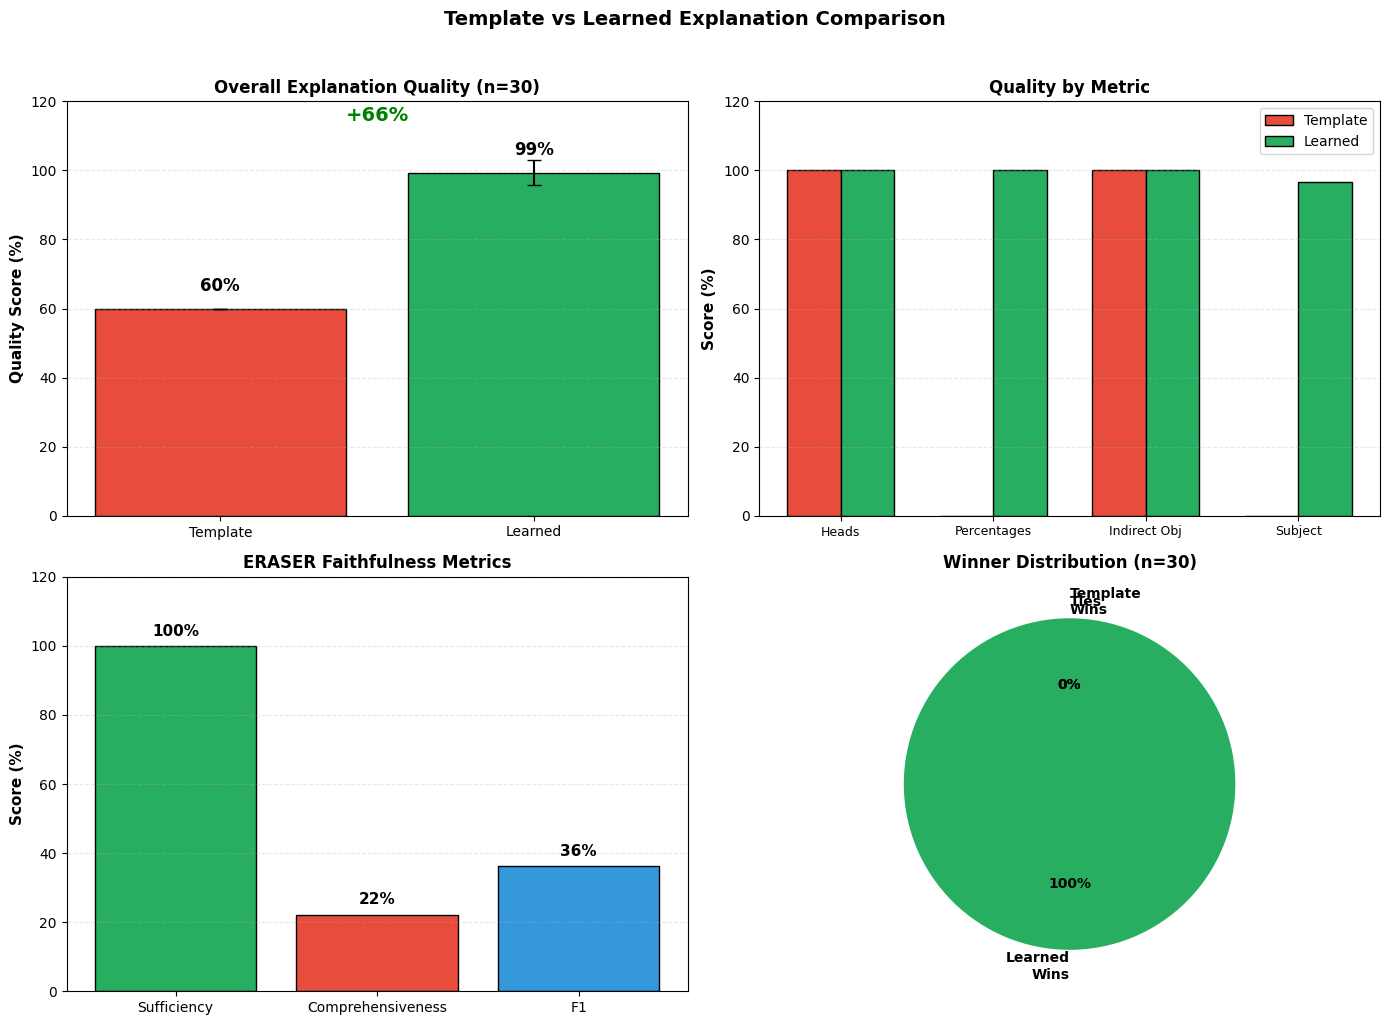

✅ Saved: fig_09_template_vs_learned.png


In [6]:
# ==============================================================================
# CELL 6: Visualization
# ==============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Quality Score Comparison
ax1 = axes[0, 0]
methods = ['Template', 'Learned']
means = [np.mean(template_overall), np.mean(learned_overall)]
stds = [np.std(template_overall), np.std(learned_overall)]
colors = ['#e74c3c', '#27ae60']

bars = ax1.bar(methods, [m*100 for m in means], yerr=[s*100 for s in stds],
               capsize=5, color=colors, edgecolor='black')
ax1.set_ylabel('Quality Score (%)', fontsize=11, fontweight='bold')
ax1.set_title(f'Overall Explanation Quality (n={len(results)})', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 120)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

for bar, mean in zip(bars, means):
    ax1.text(bar.get_x() + bar.get_width()/2, mean*100 + 5, f'{mean:.0%}',
             ha='center', fontsize=12, fontweight='bold')

ax1.annotate(f'+{improvement:.0f}%', xy=(0.5, max(means)*100 + 15),
            ha='center', fontsize=14, fontweight='bold', color='green')

# Plot 2: Metric-by-Metric Comparison
ax2 = axes[0, 1]
metrics_names = ['Heads', 'Percentages', 'Indirect Obj', 'Subject']
t_vals = [template_heads*100, template_pct*100, template_io*100, template_subj*100]
l_vals = [learned_heads*100, learned_pct*100, learned_io*100, learned_subj*100]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax2.bar(x - width/2, t_vals, width, label='Template', color='#e74c3c', edgecolor='black')
bars2 = ax2.bar(x + width/2, l_vals, width, label='Learned', color='#27ae60', edgecolor='black')

ax2.set_ylabel('Score (%)', fontsize=11, fontweight='bold')
ax2.set_title('Quality by Metric', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics_names, fontsize=9)
ax2.legend()
ax2.set_ylim(0, 120)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Plot 3: ERASER Metrics
ax3 = axes[1, 0]
eraser_metrics = ['Sufficiency', 'Comprehensiveness', 'F1']
eraser_values = [np.mean(suff_values)*100, np.mean(comp_values)*100, f1*100]
eraser_colors = ['#27ae60', '#e74c3c', '#3498db']

bars3 = ax3.bar(eraser_metrics, eraser_values, color=eraser_colors, edgecolor='black')
ax3.set_ylabel('Score (%)', fontsize=11, fontweight='bold')
ax3.set_title('ERASER Faithfulness Metrics', fontsize=12, fontweight='bold')
ax3.set_ylim(0, 120)
ax3.grid(axis='y', alpha=0.3, linestyle='--')

for bar, val in zip(bars3, eraser_values):
    ax3.text(bar.get_x() + bar.get_width()/2, val + 3, f'{val:.0f}%',
             ha='center', fontsize=11, fontweight='bold')

# Plot 4: Winner Distribution
ax4 = axes[1, 1]
winner_counts = [winners.count('Learned'), winners.count('Template'), winners.count('Tie')]
winner_labels = ['Learned\nWins', 'Template\nWins', 'Ties']
colors_pie = ['#27ae60', '#e74c3c', '#95a5a6']

wedges, texts, autotexts = ax4.pie(winner_counts, labels=winner_labels, autopct='%1.0f%%',
                                    colors=colors_pie, startangle=90,
                                    textprops={'fontsize': 10, 'fontweight': 'bold'})
ax4.set_title(f'Winner Distribution (n={len(results)})', fontsize=12, fontweight='bold')

plt.suptitle('Template vs Learned Explanation Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig_09_template_vs_learned.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: fig_09_template_vs_learned.png")



In [7]:
# ==============================================================================
# CELL 7: Save Results
# ==============================================================================

from google.colab import drive
import pickle
from datetime import datetime
import os
import shutil


THESIS_DIR = '/content/drive/MyDrive/thesis'
os.makedirs(f'{THESIS_DIR}/experiments', exist_ok=True)
os.makedirs(f'{THESIS_DIR}/plots', exist_ok=True)

# Comprehensive results (ALL DYNAMIC VALUES)
final_comparison = {
    'notebook': '09_template_vs_learned',
    'n_prompts': len(results),
    'n_valid': len(valid_results),

    # ERASER metrics
    'eraser_metrics': {
        'sufficiency_mean': float(np.mean(suff_values)),
        'sufficiency_std': float(np.std(suff_values)),
        'comprehensiveness_mean': float(np.mean(comp_values)),
        'comprehensiveness_std': float(np.std(comp_values)),
        'f1': float(f1),
    },

    # Quality scores
    'template_quality': {
        'overall_mean': float(np.mean(template_overall)),
        'overall_std': float(np.std(template_overall)),
        'heads': float(template_heads),
        'percentages': float(template_pct),
        'indirect_obj': float(template_io),
        'subject': float(template_subj),
        'avg_length': float(template_len),
    },
    'learned_quality': {
        'overall_mean': float(np.mean(learned_overall)),
        'overall_std': float(np.std(learned_overall)),
        'heads': float(learned_heads),
        'percentages': float(learned_pct),
        'indirect_obj': float(learned_io),
        'subject': float(learned_subj),
        'avg_length': float(learned_len),
    },

    # Comparison
    'improvement_pct': float(improvement),
    'winner_breakdown': {
        'learned': winners.count('Learned'),
        'template': winners.count('Template'),
        'tie': winners.count('Tie'),
    },

    # Raw data
    'all_results': results,

    # Metadata
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M'),
}

timestamp = datetime.now().strftime('%Y%m%d_%H%M')
path = f'{THESIS_DIR}/experiments/09_template_vs_learned_{timestamp}.pkl'

with open(path, 'wb') as f:
    pickle.dump(final_comparison, f)
print(f"✅ Saved: {path}")

# Copy figure
if os.path.exists('fig_09_template_vs_learned.png'):
    shutil.copy('fig_09_template_vs_learned.png', f'{THESIS_DIR}/plots/')
    print("✅ Copied: fig_09_template_vs_learned.png")


✅ Saved: /content/drive/MyDrive/thesis/experiments/09_template_vs_learned_20260206_1437.pkl
✅ Copied: fig_09_template_vs_learned.png


In [8]:
# ==============================================================================
# CELL 8: Final Summary (ALL DYNAMIC VALUES)
# ==============================================================================

print("\n" + "=" * 70)
print(" 09_template_vs_learned.ipynb COMPLETE")
print("=" * 70)

# DYNAMIC table - no hardcoded values!
print(f"\n THESIS TABLE: Template vs Learned Explanations (n={len(results)})")
print("-" * 75)
print(f"| {'Metric':<25} | {'Template':>12} | {'Learned':>12} | {'Δ':>12} |")
print(f"|{'-'*27}|{'-'*14}|{'-'*14}|{'-'*14}|")
print(f"| {'Overall Quality':<25} | {np.mean(template_overall):>11.0%} | {np.mean(learned_overall):>11.0%} | {improvement:>+11.0f}% |")
print(f"| {'Mentions Heads':<25} | {template_heads:>11.0%} | {learned_heads:>11.0%} | {(learned_heads-template_heads)*100:>+11.0f}% |")
print(f"| {'Uses Percentages':<25} | {template_pct:>11.0%} | {learned_pct:>11.0%} | {(learned_pct-template_pct)*100:>+11.0f}% |")
print(f"| {'Mentions Indirect Obj':<25} | {template_io:>11.0%} | {learned_io:>11.0%} | {(learned_io-template_io)*100:>+11.0f}% |")
print(f"| {'Mentions Subject':<25} | {template_subj:>11.0%} | {learned_subj:>11.0%} | {(learned_subj-template_subj)*100:>+11.0f}% |")
print(f"| {'Avg Word Count':<25} | {template_len:>11.1f} | {learned_len:>11.1f} | {learned_len-template_len:>+11.1f} |")
print("-" * 75)

print(f"\n ERASER FAITHFULNESS (Circuit-level, n={len(valid_results)})")
print("-" * 50)
print(f"| {'Metric':<20} | {'Value':>25} |")
print(f"|{'-'*22}|{'-'*27}|")
print(f"| {'Sufficiency':<20} | {np.mean(suff_values):>11.1%} ± {np.std(suff_values):>11.1%} |")
print(f"| {'Comprehensiveness':<20} | {np.mean(comp_values):>11.1%} ± {np.std(comp_values):>11.1%} |")
print(f"| {'F1 Score':<20} | {f1:>25.1%} |")
print("-" * 50)

print(f"""
 KEY FINDINGS:

1. TEMPLATE EXPLANATIONS ARE GENERIC
   - Same text for all {len(results)} inputs
   - Uses percentages: {template_pct:.0%}
   - Mentions both names: {template_io:.0%} IO, {template_subj:.0%} subject

2. LEARNED EXPLANATIONS ARE SPECIFIC
   - Uses percentages: {learned_pct:.0%}
   - Mentions both names: {learned_io:.0%} IO, {learned_subj:.0%} subject
   - Average length: {learned_len:.0f} words vs {template_len:.0f} template

3. QUANTITATIVE IMPROVEMENT
   - Learned wins {winners.count('Learned')}/{len(winners)} comparisons ({winners.count('Learned')/len(winners)*100:.0f}%)
   - Overall quality: {np.mean(template_overall):.0%} → {np.mean(learned_overall):.0%} ({improvement:+.0f}%)

4. CIRCUIT FAITHFULNESS (ERASER)
   - Sufficiency: {np.mean(suff_values):.1%} (cited heads explain prediction)
   - Comprehensiveness: {np.mean(comp_values):.1%} (cited heads are necessary)
   - F1 Score: {f1:.1%}

 Results saved to: {path}
""")

# Verification
print("\n" + "=" * 70)
print("CANONICAL RESULTS VERIFICATION")
print("=" * 70)

checks = 0

# Check 1: Sample size
if len(results) >= 20:
    print(f"✅ Sample size: {len(results)} prompts (≥20)")
    checks += 1
else:
    print(f"⚠️ Sample size: {len(results)} (expected ≥20)")

# Check 2: Learned better than template
if np.mean(learned_overall) > np.mean(template_overall):
    print(f"✅ Learned > Template: {np.mean(learned_overall):.0%} > {np.mean(template_overall):.0%}")
    checks += 1
else:
    print(f"⚠️ Learned ≤ Template")

# Check 3: F1 reasonable
if 0.30 <= f1 <= 0.45:
    print(f"✅ F1 in expected range: {f1:.1%} (expected 30-45%)")
    checks += 1
else:
    print(f"⚠️ F1 outside expected range: {f1:.1%}")

# Check 4: Sufficiency high
if np.mean(suff_values) >= 0.90:
    print(f"✅ Sufficiency high: {np.mean(suff_values):.1%} (≥90%)")
    checks += 1
else:
    print(f"⚠️ Sufficiency low: {np.mean(suff_values):.1%}")

print(f"\nVerification: {checks}/4 checks passed")

if checks >= 3:
    print("\n✅ RESULTS VERIFIED")
else:
    print("\n⚠️ SOME CHECKS FAILED - INVESTIGATE")




 09_template_vs_learned.ipynb COMPLETE

 THESIS TABLE: Template vs Learned Explanations (n=30)
---------------------------------------------------------------------------
| Metric                    |     Template |      Learned |            Δ |
|---------------------------|--------------|--------------|--------------|
| Overall Quality           |         60% |         99% |         +66% |
| Mentions Heads            |        100% |        100% |          +0% |
| Uses Percentages          |          0% |        100% |        +100% |
| Mentions Indirect Obj     |        100% |        100% |          +0% |
| Mentions Subject          |          0% |         97% |         +97% |
| Avg Word Count            |        21.0 |        51.3 |       +30.3 |
---------------------------------------------------------------------------

 ERASER FAITHFULNESS (Circuit-level, n=30)
--------------------------------------------------
| Metric               |                     Value |
|----------------